In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,Bidirectional,LSTM
from tensorflow.keras.optimizers import Adam

In [1]:
import pandas as pd
import numpy as np

In [3]:
from tqdm import tqdm
from time import time

In [4]:
df_train=pd.read_csv('train.txt')
df_test=pd.read_csv('test_samples.txt')

In [5]:
df_train

,tweet_id,sentiment,tweet_text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
...,...,...,...
21460,522949024132112384,neutral,"the day after newark ill be able to say """"i me..."
21461,522372593312350209,neutral,FEC hold farewell session for seven ministers ...
21462,522515200592052224,neutral,Luca Di Montezemolo (who's last day was Monday...
21463,523089087155437568,positive,Coffee is pretty much the answer to all questi...


In [6]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [7]:
%%time 
import re
train_text=' '.join(df_train['tweet_text'])
train_text=train_text.split()
freq_comm=pd.Series(train_text).value_counts()
rare=freq_comm[freq_comm.values==1]

Wall time: 158 ms


We see the following are the top 10 frequent words which occur in our corpus.

In [8]:
freq_comm[:10]

the    16389
to      9847
on      6061
in      6031
a       5571
and     5518
I       5352
of      4941
for     4517
is      4163
dtype: int64

...and the following are 10 of the most rare words of our corpus.

In [9]:
rare

@casey22rolltide          1
meatloaf.                 1
Gedman\u002c              1
\u2019canes\u002c         1
4:09                      1
                         ..
@GatorBoyBitchhh          1
http://t.co/8qJUmyaTK7    1
\""Little                 1
MH370                     1
#Beyday                   1
Length: 55101, dtype: int64

In [10]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [11]:
def clean_text(txt):
    if(type(txt) is str):
        txt=txt.lower()
        for key in contractions:
            value=contractions[key]
            txt=txt.replace(key,value)
        txt=re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9+._-]+\.[a-zA-Z0-9+._-])','',txt)
        txt=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", txt)
        txt=re.sub('RT','',txt)
        txt=re.sub(r'[^\x00-\x7F]+',' ', txt)
        txt=emoji_pattern.sub(r'', txt)
        txt=' '.join([t for t in txt.split() if t not in rare])
        return txt
    else:
        return txt

In [12]:
df_train['tweet_text'].values.tolist()[:5]

['Gas by my house hit $3.39!!!! I\\u2019m going to Chapel Hill on Sat. :)',
 'Theo Walcott is still shit\\u002c watch Rafa and Johnny deal with him on Saturday.',
 'its not that I\\u2019m a GSP fan\\u002c i just hate Nick Diaz. can\\u2019t wait for february.',
 'Iranian general says Israel\\u2019s Iron Dome can\\u2019t deal with their missiles (keep talking like that and we may end up finding out)',
 'Tehran\\u002c Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney']

In [13]:
%%time
df_train['tweet_text']=df_train['tweet_text'].apply(lambda x:clean_text(x))
df_test['tweet_text']=df_test['tweet_text'].apply(lambda x:clean_text(x))

Wall time: 1.59 s


In [35]:
df_train['tweet_text'].values.tolist()[:5]

['gas by my house hit i\\u2019m going to chapel hill on sat. :)',
 'theo walcott is still shit\\u002c watch and johnny deal with him on saturday.',
 'its not that i\\u2019m a gsp fan\\u002c i just hate diaz. can\\u2019t wait for',
 'iranian general says israel\\u2019s dome can\\u2019t deal with their (keep talking like that and we may end up finding out)',
 'tehran\\u002c mon amour: obama tried to establish ties with the mullahs via @pjmedia_com no obama - vote mitt romney']

In [36]:
df_train['tweet_text']

0        gas by my house hit i\u2019m going to chapel h...
1        theo walcott is still shit\u002c watch and joh...
2        its not that i\u2019m a gsp fan\u002c i just h...
3        iranian general says israel\u2019s dome can\u2...
4        tehran\u002c mon amour: obama tried to establi...
                               ...                        
21460    the day after ill be able to say met demi lova...
21461    fec hold farewell session for seven - presiden...
21462    luca di montezemolo (who has / who is last day...
21463    coffee is pretty much the answer to all questi...
21464    niki lauda just confirmed to sky that alonso w...
Name: tweet_text, Length: 21465, dtype: object

In [37]:
df_train['sentiment'].value_counts()

positive    9064
neutral     9014
negative    3387
Name: sentiment, dtype: int64

In [14]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labels=df_train['sentiment'].values
le=LabelEncoder()
le_labels=le.fit_transform(labels)

In [15]:
ohe=OneHotEncoder()
ohe_labels=ohe.fit_transform(le_labels.reshape(-1,1))

In [16]:
train_text=df_train['tweet_text'].values.tolist()

In [17]:
test_text=df_test['tweet_text'].values.tolist()

In [18]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_text)

In [19]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

24492

In [44]:
print(tokenizer.index_word)

{1: 'the', 2: 'to', 3: 'i', 4: 'on', 5: 'in', 6: 'a', 7: 'and', 8: 'is', 9: 'of', 10: 'it', 11: 'for', 12: 'you', 13: 'with', 14: 'u002c', 15: 'tomorrow', 16: 'at', 17: 'be', 18: 'may', 19: 'that', 20: 'my', 21: 'not', 22: 'have', 23: 'will', 24: 'this', 25: 'has', 26: 'he', 27: 'just', 28: 'day', 29: 'u2019s', 30: 'but', 31: 'was', 32: 'going', 33: 'are', 34: 'we', 35: 'night', 36: 'out', 37: 'me', 38: 'all', 39: 'so', 40: 'if', 41: 'from', 42: 'see', 43: 'friday', 44: '1st', 45: 'like', 46: 'time', 47: 'about', 48: 'up', 49: 'game', 50: 'get', 51: 'saturday', 52: 'sunday', 53: 'as', 54: 'do', 55: 'can', 56: 'go', 57: 'new', 58: 'one', 59: 'what', 60: 'by', 61: '2nd', 62: 'tonight', 63: 'they', 64: 'today', 65: "i'm", 66: 'u2019t', 67: 'or', 68: 'now', 69: 'your', 70: 'his', 71: 'good', 72: 'when', 73: '2', 74: 'watch', 75: 'monday', 76: 'an', 77: 'there', 78: 'last', 79: 'who', 80: '3rd', 81: 'amp', 82: 'thursday', 83: 'make', 84: 'want', 85: 'no', 86: 'us', 87: 'think', 88: 'back', 

In [20]:
encoded_text=tokenizer.texts_to_sequences(train_text)

In [21]:
encoded_test=tokenizer.texts_to_sequences(test_text)

In [47]:
encoded_text[:3]

[[3607, 60, 20, 237, 469, 3, 92, 32, 2, 2842, 1532, 4, 117],
 [5691, 6644, 8, 95, 293, 14, 74, 7, 2683, 521, 13, 147, 4, 51],
 [142, 21, 19, 3, 92, 6, 8174, 543, 14, 3, 27, 577, 3277, 55, 66, 125, 11]]

In [48]:
max_len_in_train=0
for text in train_text:
    if(len(text.split())>max_len_in_train):
        max_len_in_train=len(text.split())
print(f'maxmimum size of tweet in training data {max_len_in_train}')

maxmimum size of tweet in training data 1006


In [28]:
max_length=300
x=pad_sequences(encoded_text,maxlen=max_length,padding='post')

In [23]:
test_x=x=pad_sequences(encoded_test,maxlen=max_length,padding='post')

In [51]:
x[1000]

array([   65,   246,  1000,  1731,    19,  6285,    23,  1110,     6,
       11532,    15,   619,  5811,     2,  4007,     1,  1692, 20069,
        1001,  1384,    71,   521,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [29]:
x.shape

(21465, 300)

# Glove Embeddings

In [24]:
glove_vectors={}
embedding_path='D:\datasets\glove_twitter_50_100_200\glove.twitter.27B.200d.txt'

In [25]:
%%time
file=open(embedding_path,encoding='utf-8')
for line in file:
    values=line.split()
    word=values[0]
    vectors=np.asarray(values[1:])
    glove_vectors[word]=vectors

Wall time: 45 s


In [55]:
list(glove_vectors.keys())[:10]

['<user>',
 '.',
 ':',
 'rt',
 ',',
 '<repeat>',
 '<hashtag>',
 '<number>',
 '<url>',
 '!']

In [56]:
len(glove_vectors.keys())

1193514

In [26]:
embedding_matrix=np.zeros((vocab_size,200))
nalist=[]
for word,index in tokenizer.word_index.items():
    vector=glove_vectors.get(word)
    if(vector is not None):
        embedding_matrix[index]=vector
    else:
        nalist.append(word)

In [58]:
print(nalist[:110])

['u002c', 'u2019s', '1st', '2nd', "i'm", 'u2019t', '2', '3rd', 'u2019m', '3', '1', '4th', '4', '5', 'u2019ll', '5th', '6', '10', "i'll", '7', '6th', 'u2019', 'u2019re', '7th', '30', '8', '8th', '9', '10th', 'u2019ve', '2012', '12', '9th', "i've", '15', '0', '16', '14th', '11', '15th', '20th', '20', '25', 'u2019d', '24', '17', '2015', '16th', '25th', '11th', '19', '30th', 'u2019mon', '13th', '13', '12th', '17th', '19th', '26', '8pm', '21st', '14', '18th', '27th', '22', '50', '28', "obama's", "here's", '18', '21', "i'd", "tomorrow's", '26th', '23', '00', '24th', '28th', '27', '2014', '7pm', '29th', '100', '29', '6pm', "today's", "apple's", '31st', '31', '22nd', 'u2019all', '23rd', "tonight's", '6s', "flair's", '30pm', '9pm', "beyonce's", '2013', '10pm', "madonna's", 'realdonaldtrump', "hillary's", 's6', '10am', '9am', '40', '4pm', '2016', "knott's"]


In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,ohe_labels.todense(),test_size=0.1,stratify=ohe_labels.todense())

In [31]:
vec_size=200
model=Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=max_length,weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.0)))
model.add(Conv1D(64,8,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(32,8,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(3,activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          4898400   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 100)          100400    
_________________________________________________________________
conv1d (Conv1D)              (None, 293, 64)           51264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 146, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 146, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 139, 32)           16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 69, 32)            0

In [33]:
model.save('glove_model.h5')

In [34]:
history=model.fit(x_train,y_train,epochs=40,validation_data=(x_test,y_test))

Epoch 1/40
604/604 [==============================] - 20s 33ms/step - loss: 1.0500 - accuracy: 0.4207 - val_loss: 1.0188 - val_accuracy: 0.4541
Epoch 2/40
604/604 [==============================] - 19s 32ms/step - loss: 0.9838 - accuracy: 0.4386 - val_loss: 0.9758 - val_accuracy: 0.4224
Epoch 3/40
604/604 [==============================] - 20s 33ms/step - loss: 0.9364 - accuracy: 0.4980 - val_loss: 0.9370 - val_accuracy: 0.5468
Epoch 4/40
604/604 [==============================] - 19s 32ms/step - loss: 0.8768 - accuracy: 0.5591 - val_loss: 0.9216 - val_accuracy: 0.5664
Epoch 5/40
604/604 [==============================] - 19s 32ms/step - loss: 0.8521 - accuracy: 0.5840 - val_loss: 0.9208 - val_accuracy: 0.5897
Epoch 6/40
604/604 [==============================] - 19s 32ms/step - loss: 0.8346 - accuracy: 0.5990 - val_loss: 0.9067 - val_accuracy: 0.5980
Epoch 7/40
604/604 [==============================] - 19s 32ms/step - loss: 0.8222 - accuracy: 0.6088 - val_loss: 0.9178 - val_accuracy:

In [35]:
epchs=range(1,41)

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


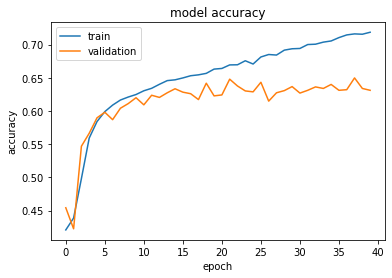

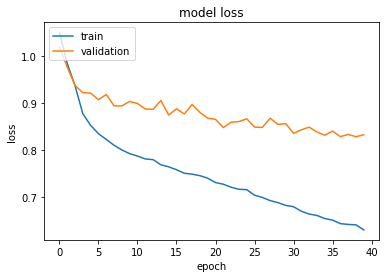

In [47]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
def encode_test(txt):
    txt=clean_text(txt)
    txt=tokenizer.texts_to_sequences(txt)
    txt=pad_sequences(txt,maxlen=max_length,padding='post')
    return txt

In [48]:
test_data=[]
for text in df_test['tweet_text'].values.tolist():
    test_data.append(encode_test(text))

In [50]:
test_data_arr=np.array(test_data)

In [70]:
predictions=model.predict_classes(test_x)

In [71]:
preds=le.inverse_transform(predictions)

In [72]:
np.unique(preds,return_counts=True)

(array(['negative', 'neutral', 'positive'], dtype=object),
 array([ 306, 2927, 2165], dtype=int64))

In [73]:
pred_df=pd.DataFrame({'tweet_id':df_test['tweet_id'].values,'sentiment':preds})

In [74]:
pred_df

,tweet_id,sentiment
0,264238274963451904,neutral
1,218775148495515649,positive
2,258965201766998017,neutral
3,262926411352903682,neutral
4,171874368908050432,neutral
...,...,...
5393,210378118865756160,neutral
5394,245177521304399872,positive
5395,259280987089932288,positive
5396,201113950211940352,neutral


In [75]:
pred_df.to_csv('glove_cnn1d_2.csv',index=False)

In [ ]:
# embed_size=200
# max_features=130000
# max_length=220

In [ ]:
# classes=df_train['sentiment'].unique

In [ ]:
# ls "D:\datasets\glove_twitter_50_100_200"

In [ ]:
# x_train_raw=df_train['tweet_text'].str.lower()
# x_test_raw=df_test['tweet_text'].str.lower()

In [ ]:
# tk=Tokenizer(num_words=max_features,lower=True)
# tk.fit_on_texts(x_train_raw)

In [ ]:
# df_train['tweet_seq']=tk.texts_to_sequences(x_train_raw)
# df_test['tweet_seq']=tk.texts_to_sequences(x_test_raw)

In [ ]:
# df_train

In [ ]:
# x_train=pad_sequences(df_train.tweet_seq,maxlen=max_length)
# x_test=pad_sequences(df_test.tweet_seq,maxlen=max_length)

In [ ]:
# x_train.shape

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# ohe=OneHotEncoder()
# y_train=ohe.fit_transform(df_train['sentiment'].values.reshape(-1,1)).todense()

In [ ]:
# def get_coefs(word,*arr):
#     return word, np.asarray(arr, dtype='float32')

In [ ]:
# embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embedding_path,encoding="utf-8")))

In [ ]:
# word_index=tk.word_index
# nb_words=min(max_features,len(word_index))
# print(f'nb_words : {nb_words}')

In [ ]:
# vocab_size=len(tk.word_index)+1

In [ ]:
# embedding_matrix=np.zeros((vocab_size,embed_size))

In [ ]:
# for word,i in word_index.items():
#     if(i>=max_features):
#         continue
#     embedding_vector=embedding_index.get(word)
#     if(embedding_vector) is not None:
#         embedding_matrix[i]=embedding_vector

In [ ]:
# embedding_matrix

In [ ]:
# from keras.optimizers import Adam, RMSprop
# from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# from keras.layers import BatchNormalization

In [ ]:
# def get_model(lr=0.0,lr_d=0.0,units=0,dr=0.9):
#     inp = Input(shape=(max_length,))
#     x = Embedding(vocab_size, embed_size, weights=[embedding_matrix])(inp)
#     x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.0))(x)
#     x = GlobalMaxPool1D()(x)
#     x = Dense(50, activation="relu")(x)
#     x = Dropout(0.1)(x)
#     x = Dense(3, activation="sigmoid")(x)
#     model = Model(inputs=inp, outputs=x)
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [ ]:
# model=get_model(lr = 1e-3, lr_d = 0, units = 128, dr = 0.2)

In [ ]:
# model.summary()

In [ ]:
# x_train.max()

In [ ]:
# history=model.fit(x_train,y_train,batch_size=64,epochs=4,validation_split=0.05)

In [ ]:
# predictions=model.predict(x_test)

In [ ]:
# actual_preds=np.argmax(predictions,axis=1)

In [ ]:
# y_train

In [ ]:
# df_train

In [ ]:
# #positive 001 negative 100 neutral 010
# #positve 3 negative 1 neutral 2
# act_dict={'0':'negative','1':'neutral','2':'postive'}

In [ ]:
# actuals=[]
# for i in actual_preds:
#     actuals.append(act_dict[str(i)])

In [ ]:
# pred_df=pd.DataFrame({'tweet_id':df_test['tweet_id'].values,'sentiment':actuals})

In [ ]:
# pred_df.to_csv('glove_gru_lstm_cnn.csv',index=False)

In [ ]:
# pred_df

In [ ]:
# np.unique(pred_df.sentiment.values,return_counts=True)